In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

import keras_tuner as kt

In [63]:
# Load data
data = pd.read_csv('Dataset1.csv', parse_dates=['Tanggal'], dayfirst=True)

In [64]:
numeric_cols = ['Pembukaan', 'Tertinggi', 'Terendah', 'Terakhir']
for col in numeric_cols:
    data[col] = data[col].str.replace(',', '.').astype(float)

In [65]:
# Mengganti tanda koma dengan titik dalam kolom Vol.
data['Vol.'] = data['Vol.'].str.replace(',', '').str.replace('M', '').astype(float) * 1e6

# Mengonversi kolom Change% menjadi desimal
data['Perubahan%'] = data['Perubahan%'].str.replace(',', '.').str.replace('%', '').astype(float) / 100

In [66]:
# Preprocess data
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data.set_index('Tanggal', inplace=True)

In [67]:
data = data.sort_values('Tanggal')

In [68]:
# Data Imputation
df_unsampled = data.resample('D').asfreq().interpolate(method='linear')
df_unsampled.reset_index(inplace=True)
df_unsampled = df_unsampled.sort_values('Tanggal')

In [69]:
# Pilih fitur
temp_X = df_unsampled.copy()
temp_y = df_unsampled.copy()
X = temp_X[['Pembukaan', 'Tertinggi', 'Terendah']].iloc[:-1,:]
y = temp_y['Terakhir'].shift(-1).dropna()

In [70]:
y= pd.DataFrame(y)

In [71]:
X_train = X.copy()
y_train = y.copy()
X_test = X.copy()
y_test = y.copy()

In [72]:
# Bagi data menjadi data pelatihan dan data pengujian
X_train = X_train.drop(X_train[2993:].index)
y_train = y_train.drop(y_train[2993:].index)
X_test = X_test.drop(X_test[:-749].index)
y_test = y_test.drop(y_test[:-749].index)

X_train2 = X_train.copy()
y_train2 = y_train.copy()
X_test2 = X_test.copy()
y_test2 = y_test.copy()

In [73]:
# Scaling Data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train2 = scaler_X.fit_transform(X_train2)
X_test2 = scaler_X.transform(X_test2)
y_train2 = scaler_y.fit_transform(y_train2)
y_test2 = scaler_y.transform(y_test2)

In [74]:
n_val = int(0.2 * len(X_train2))  # 20% dari jumlah data pelatihan

# Mengambil 20% data terakhir untuk validasi
X_val_split = X_train2[-n_val:]
y_val_split = y_train2[-n_val:]

In [75]:
# Function to create dataset with given time step
def create_dataset(dataset_X, dataset_y, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset_X) - time_step):
        dataX.append(dataset_X[i:(i + time_step), :])
        dataY.append(dataset_y[i + time_step])
    return np.array(dataX), np.array(dataY)

time_step = 10
X_train2, y_train2 = create_dataset(X_train2, y_train2, time_step)
X_test2, y_test2 = create_dataset(X_test2, y_test2, time_step)
X_val_split, y_val_split = create_dataset(X_val_split, y_val_split, time_step)

In [76]:
# Reshape input to be [samples, time steps, features]
X_train2 = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], X_train2.shape[2])
X_test2 = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], X_test2.shape[2])
X_val_split = X_val_split.reshape(X_val_split.shape[0], X_val_split.shape[1],X_val_split.shape[2])

In [77]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train2.shape[1], X_train2.shape[2])))  # Menambahkan Input layer sebagai layer pertama

    for i in range(hp.Int('n_layers', 1, 3)):
        model.add(LSTM(units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
                       return_sequences=True if i < hp.Int('n_layers', 1, 3) - 1 else False))
        model.add(Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    model.add(Dense(1))
    
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error')
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='GLD_price_prediction Finals')

tuner.search(X_train2, y_train2, epochs=50, validation_split=0.2, verbose=2)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of layers is {best_hps.get('n_layers')}.
The optimal number of units in the layers are {[best_hps.get(f'units_{i}') for i in range(best_hps.get('n_layers'))]}.
The optimal dropout rates are {[best_hps.get(f'dropout_{i}') for i in range(best_hps.get('n_layers'))]}.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")

Reloading Tuner from kt_dir/GLD_price_prediction Finals/tuner0.json

The hyperparameter search is complete. The optimal number of layers is 2.
The optimal number of units in the layers are [96, 96].
The optimal dropout rates are [0.1, 0.2].
The optimal learning rate is 0.0021477111334815414.



In [78]:
# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hps)

In [79]:
history = model.fit(X_train2, y_train2, epochs=50, validation_split=0.2, verbose=2)

Epoch 1/50
75/75 - 4s - 56ms/step - loss: 0.0030 - val_loss: 0.0024
Epoch 2/50
75/75 - 1s - 11ms/step - loss: 9.0270e-04 - val_loss: 0.0028
Epoch 3/50
75/75 - 1s - 11ms/step - loss: 9.5992e-04 - val_loss: 0.0024
Epoch 4/50
75/75 - 1s - 11ms/step - loss: 9.0738e-04 - val_loss: 0.0171
Epoch 5/50
75/75 - 1s - 11ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 6/50
75/75 - 1s - 12ms/step - loss: 7.7582e-04 - val_loss: 8.3738e-04
Epoch 7/50
75/75 - 1s - 11ms/step - loss: 7.9871e-04 - val_loss: 0.0011
Epoch 8/50
75/75 - 1s - 11ms/step - loss: 7.0256e-04 - val_loss: 0.0013
Epoch 9/50
75/75 - 1s - 11ms/step - loss: 5.9554e-04 - val_loss: 0.0013
Epoch 10/50
75/75 - 1s - 11ms/step - loss: 5.9303e-04 - val_loss: 0.0018
Epoch 11/50
75/75 - 1s - 11ms/step - loss: 5.7311e-04 - val_loss: 8.5112e-04
Epoch 12/50
75/75 - 1s - 11ms/step - loss: 5.3908e-04 - val_loss: 8.1413e-04
Epoch 13/50
75/75 - 1s - 11ms/step - loss: 5.0345e-04 - val_loss: 0.0017
Epoch 14/50
75/75 - 1s - 11ms/step - loss: 5.6654e-04 - 

In [80]:
val_pred = model.predict(X_val_split)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [81]:
mse_val = mean_squared_error(y_val_split, val_pred)
r2_val = r2_score(y_val_split, val_pred)
mape_val = mean_absolute_percentage_error(y_val_split, val_pred)

In [82]:
print(f'MSE pada data validasi: {mse_val}')
print(f'R-squared pada data validasi: {r2_val}')
print(f'MAPE pada data validasi: {mape_val}')

MSE pada data validasi: 0.0005431415494335292
R-squared pada data validasi: 0.8918294175530727
MAPE pada data validasi: 0.02244339356345986


In [83]:
# Make prediction
y_pred = model.predict(X_test2)

# Evaluate the model
mse = mean_squared_error(y_test2, y_pred)
print(f'MSE: {mse}')

# Calculate R-Squared
r2 = r2_score(y_test2, y_pred)
print(f'R-Squared: {r2}')

# Calculate MAPE
mape = mean_absolute_percentage_error(y_test2, y_pred)
print(f'MAPE: {mape}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 0.000461477103888982
R-Squared: 0.9686393999631742
MAPE: 0.02134172356444071


In [84]:
y_pred = scaler_y.inverse_transform(y_pred)

In [85]:
y_test2 = scaler_y.inverse_transform(y_test2)

In [86]:
y_pred = pd.DataFrame(y_pred, columns=['Prediksi'])

In [87]:
df_pred = df_unsampled.drop(['Terakhir', 'Pembukaan', 'Tertinggi', 'Terendah', 'Vol.', 'Perubahan%'], axis=1)
df_pred = df_pred.iloc[1:]
df_pred = df_pred.reset_index(drop=True)
df_pred = df_pred.drop(df_pred[:-749].index)

In [88]:
df_pred = df_pred['Tanggal'].reset_index()

In [89]:
preds = pd.concat([df_pred, y_pred], axis=1)
preds = preds.drop(['index'], axis=1)

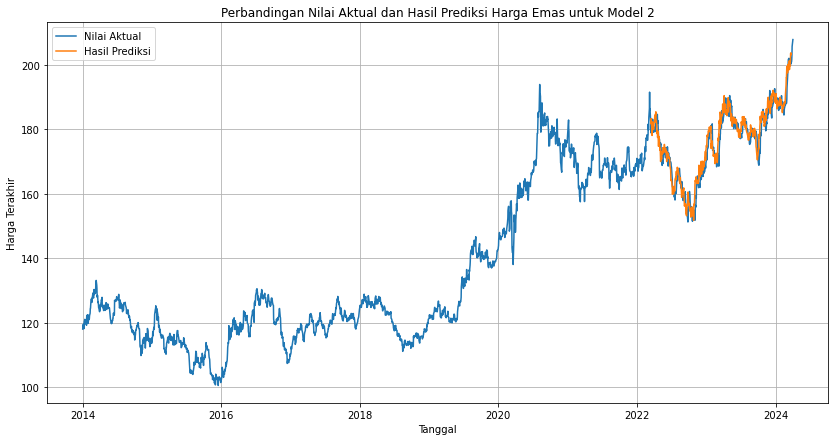

In [90]:
import seaborn as sns
plt.figure(figsize=(14, 7))
plt.plot(pd.to_datetime(df_unsampled['Tanggal']), df_unsampled['Terakhir'], label='Nilai Aktual')
plt.plot(pd.to_datetime(preds['Tanggal']),preds['Prediksi'], label='Hasil Prediksi', linestyle='-') # Use 'Prediksi Harga' instead of 'y_pred'
plt.xlabel('Tanggal')
plt.ylabel('Harga Terakhir')
plt.title('Perbandingan Nilai Aktual dan Hasil Prediksi Harga Emas untuk Model 2')
plt.legend()
plt.grid(True)
plt.show()

In [92]:
# Buat dataset untuk prediksi seluruh data
X_full = scaler_X.transform(X)
y_full = scaler_y.transform(y)

X_full, y_full = create_dataset(X_full, y_full, time_step)
X_full = X_full.reshape(X_full.shape[0], X_full.shape[1], X_full.shape[2])

# Make predictions on full dataset
y_pred_full = model.predict(X_full)

# Inverse transform predictions
y_pred_full = scaler_y.inverse_transform(y_pred_full)

# Simpan hasil prediksi ke dalam CSV
predictions = pd.DataFrame(y_pred_full, columns=['Predicted_Terakhir'])
predictions.to_csv('predicted_Terakhir_LSTM-RandomSearch.csv', index=False)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [94]:
import pandas as pd
import numpy as np
# Buat kolom 'Terakhir_pred' dengan nilai NaN
df_unsampled['Terakhir_pred'] = np.nan

# Pastikan panjang y_pred_full sesuai dengan panjang df_unsampled
if len(y_pred_full) <= len(df_unsampled):
    # Masukkan hasil prediksi ke kolom 'Terakhir_pred' menggunakan iloc
    df_unsampled.iloc[-len(y_pred_full):, df_unsampled.columns.get_loc('Terakhir_pred')] = y_pred_full.flatten()
else:
    raise ValueError("Panjang y_pred_full lebih panjang dari df_unsampled")

# Simpan DataFrame dengan kolom prediksi ke dalam CSV
df_unsampled.to_csv('data_dengan_prediksi.csv', index=False)

In [96]:
# Simulasi data baru
simulated_data = pd.DataFrame({
    'Pembukaan': [120.54],
    'Tertinggi': [121.06],
    'Terendah': [119.72]
})

# Normalisasi data simulasi
simulated_data = scaler_X.transform(simulated_data)

# Reshape input data untuk prediksi
simulated_data = simulated_data.reshape(1, simulated_data.shape[0], simulated_data.shape[1])

# Prediksi harga penutupan menggunakan model yang sudah dilatih
predicted_close = model.predict(simulated_data)

# Denormalisasi hasil prediksi
predicted_close = scaler_y.inverse_transform(predicted_close)

print(f'Prediksi harga penutupan (Close) untuk data simulasi: {predicted_close}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Prediksi harga penutupan (Close) untuk data simulasi: [[119.75046]]
